***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [4]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)

Shape of HTML dataset: (43491, 1461)


### JavaScript read data

In [5]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

In [6]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [12]:
columns=['Target',
 'a_count',
 'a_href_.com',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'area_href_out_of_domain',
 'audio_src_out_of_domain',
 'base_href_out_of_domain',
 'br_count',
 'center_count',
 'div_count',
 'dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.setInterval(',
 'dom_function_window.setTimeout(',
 'embed_count',
 'embed_src_out_of_domain',
 'form_action_http',
 'form_action_out_of_domain',
 'frame_count',
 'frame_src_out_of_domain',
 'iframe_count',
 'iframe_hidden_true',
 'iframe_src_out_of_domain',
 'img_count',
 'img_src_.jpg',
 'img_src_out_of_domain',
 'img_srcset_out_of_domain',
 'input_count',
 'js_function_.charCodeAt(',
 'js_function_.concat(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.get(',
 'js_function_.indexOf(',
 'js_function_.link(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.search(',
 'js_function_.substring(',
 'js_function_String.fromCharCode(',
 'js_function_escape(',
 'js_function_eval(',
 'js_function_parseInt(',
 'js_function_unescape(',
 'li_count',
 'link_count',
 'link_href_.css',
 'link_href_http',
 'link_href_out_of_domain',
 'link_rel_https://api.w.org/',
 'link_rel_shortlink',
 'link_type_application/rsd+xml',
 'link_type_text/css',
 'meta_count',
 'object_count',
 'object_data_out_of_domain',
 'p_count',
 'script_async_true',
 'script_src_.js',
 'script_src_out_of_domain',
 'script_type_text/javascript',
 'section_count',
 'source_src_out_of_domain',
 'source_srcset_out_of_domain',
 'span_count',
 'strong_count',
 'style_count',
 'title_count',
 'total_count',
 'total_href',
 'total_img_src',
 'video_src_out_of_domain'
]

In [14]:
df_sel=df[columns].copy(deep=True)

In [15]:
df_sel.columns.shape

(76,)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [16]:
fin_col=df_sel.columns.values.tolist()

In [17]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

In [18]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [19]:
test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [20]:
train.shape

(32567, 76)

In [21]:
columns=fin_col
columns.remove('Target')

In [22]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8739521601621273
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27663   175    27838
True        3930   799     4729
__all__    31593   974    32567

Accuracy of the model for test data is: 0.8646524195529354
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6870    70     6940
True        1032   170     1202
__all__     7902   240     8142



Logistic Regression
Accuracy of the model for training data is: 0.8946172505910891
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25425  2413    27838
True        1019  3710     4729
__all__    26444  6123    32567

Accuracy of the model for test data is: 0.8960943257184967
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6340   600     6940
True         246   956     1202
__all__     6586  1556     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9274111830994565
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25663  2175    27838
True         189  4540     4729
__all__    25852  6715    32567

Accuracy of the model for test data is: 0.9137803979366249
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6376   564     6940
True         138  1064     1202
__all__     6514  1628     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9038290293855743
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25525  2313    27838
True         819  3910     4729
__all__    26344  6223    32567

Accuracy of the model for test data is: 0.9029722426922132
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6351   589     6940
True         201  1001     1202
__all__     6552  1590     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.910922099057328
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25624  2214    27838
True         687  4042     4729
__all__    26311  6256    32567

Accuracy of the model for test data is: 0.9073937607467453
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6374   566     6940
True         188  1014     1202
__all__     6562  1580     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9293456566462984
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25668  2170    27838
True         131  4598     4729
__all__    25799  6768    32567

Accuracy of the model for test data is: 0.9130434782608695
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6375   565     6940
True         143  1059     1202
__all__     6518  1624     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9274418890287714
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25662  2176    27838
True         187  4542     4729
__all__    25849  6718    32567

Accuracy of the model for test data is: 0.9135347580447064
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6370   570     6940
True         134  1068     1202
__all__     6504  1638     8142



Neural Network-1
The accuracy of the model on training data is: 0.9149138698701018


Predicted  False  True  __all__
Actual                         
False      25440  2398    27838
True         373  4356     4729
__all__    25813  6754    32567

The accuracy of the model on test data is: 0.9034635224760501


Predicted  False  True  __all__
Actual                         
False       6301   639     6940
True         147  1055     1202
__all__     6448  1694     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.873952,799.0,27663.0,175.0,3930.0,0.006286,0.831043
LogisticRegression,0.894617,3710.0,25425.0,2413.0,1019.0,0.086680,0.215479
RandomForestClassifier,0.927411,4540.0,25663.0,2175.0,189.0,0.078131,0.039966
AdaBoostClassifier,0.903829,3910.0,25525.0,2313.0,819.0,0.083088,0.173187
GradientBoostingClassifier,0.910922,4042.0,25624.0,2214.0,687.0,0.079532,0.145274
ExtraTreeClassifier,0.929346,4598.0,25668.0,2170.0,131.0,0.077951,0.027701
BaggingClassifier,0.927442,4542.0,25662.0,2176.0,187.0,0.078167,0.039543
Neural Network-1,0.914914,4356.0,25440.0,2398.0,373.0,0.086141,0.078875


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.864652,170.0,6870.0,70.0,1032.0,0.010086,0.858569,0.565672,0.275467
LogisticRegression,0.896094,956.0,6340.0,600.0,246.0,0.086455,0.204659,0.854443,0.639577
RandomForestClassifier,0.913780,1064.0,6376.0,564.0,138.0,0.081268,0.114809,0.901962,0.713010
AdaBoostClassifier,0.902972,1001.0,6351.0,589.0,201.0,0.084870,0.167221,0.873954,0.669260
GradientBoostingClassifier,0.907394,1014.0,6374.0,566.0,188.0,0.081556,0.156406,0.881019,0.683537
ExtraTreeClassifier,0.913043,1059.0,6375.0,565.0,143.0,0.081412,0.118968,0.899810,0.709848
BaggingClassifier,0.913535,1068.0,6370.0,570.0,134.0,0.082133,0.111481,0.903193,0.713556
Neural Network-1,0.903464,1055.0,6301.0,639.0,147.0,0.092075,0.122296,0.892814,0.686563


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [26]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [27]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9353581435447949
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24807   3031    27838
True         568  27270    27838
__all__    25375  30301    55676

Accuracy of the model for test data is: 0.8840579710144928
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6094   846     6940
True          98  1104     1202
__all__     6192  1950     8142



Logistic Regression
Accuracy of the model for training data is: 0.8946943027516344
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22998   4840    27838
True        1023  26815    27838
__all__    24021  31655    55676

Accuracy of the model for test data is: 0.8450012281994596
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5737  1203     6940
True          59  1143     1202
__all__     5796  2346     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9545405560744307
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25541   2297    27838
True         234  27604    27838
__all__    25775  29901    55676

Accuracy of the model for test data is: 0.9114468189633996
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6330   610     6940
True         111  1091     1202
__all__     6441  1701     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9093684891155974
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23947   3891    27838
True        1155  26683    27838
__all__    25102  30574    55676

Accuracy of the model for test data is: 0.8741095553917956
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5995   945     6940
True          80  1122     1202
__all__     6075  2067     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.928209641497234
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24765   3073    27838
True         924  26914    27838
__all__    25689  29987    55676

Accuracy of the model for test data is: 0.8954802259887006
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True          97  1105     1202
__all__     6283  1859     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9550614268266399
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25548   2290    27838
True         212  27626    27838
__all__    25760  29916    55676

Accuracy of the model for test data is: 0.9107098992876443
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6330   610     6940
True         117  1085     1202
__all__     6447  1695     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9540735685034845
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25537   2301    27838
True         256  27582    27838
__all__    25793  29883    55676

Accuracy of the model for test data is: 0.9100957995578481
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6317   623     6940
True         109  1093     1202
__all__     6426  1716     8142



Neural Network-1
The accuracy of the model on training data is: 0.9394891874416266


Predicted  False   True  __all__
Actual                          
False      24616   3222    27838
True         147  27691    27838
__all__    24763  30913    55676

The accuracy of the model on test data is: 0.8894620486366986


Predicted  False  True  __all__
Actual                         
False       6107   833     6940
True          67  1135     1202
__all__     6174  1968     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [28]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [29]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.935358,27270.0,24807.0,3031.0,568.0,0.108880,0.020404
LogisticRegression,0.894694,26815.0,22998.0,4840.0,1023.0,0.173863,0.036748
RandomForestClassifier,0.954541,27604.0,25541.0,2297.0,234.0,0.082513,0.008406
AdaBoostClassifier,0.909368,26683.0,23947.0,3891.0,1155.0,0.139773,0.041490
GradientBoostingClassifier,0.928210,26914.0,24765.0,3073.0,924.0,0.110389,0.033192
ExtraTreeClassifier,0.955061,27626.0,25548.0,2290.0,212.0,0.082262,0.007615
BaggingClassifier,0.954074,27582.0,25537.0,2301.0,256.0,0.082657,0.009196
Neural Network-1,0.939489,27691.0,24616.0,3222.0,147.0,0.115741,0.005281


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.884058,1104.0,6094.0,846.0,98.0,0.121902,0.081531,0.898284,0.662097
LogisticRegression,0.845001,1143.0,5737.0,1203.0,59.0,0.173343,0.049085,0.888786,0.609038
RandomForestClassifier,0.911447,1091.0,6330.0,610.0,111.0,0.087896,0.092346,0.909879,0.715301
AdaBoostClassifier,0.874110,1122.0,5995.0,945.0,80.0,0.136167,0.066556,0.898639,0.649827
GradientBoostingClassifier,0.895480,1105.0,6186.0,754.0,97.0,0.108646,0.080699,0.905328,0.685086
ExtraTreeClassifier,0.910710,1085.0,6330.0,610.0,117.0,0.087896,0.097338,0.907383,0.711871
BaggingClassifier,0.910096,1093.0,6317.0,623.0,109.0,0.089769,0.090682,0.909774,0.712816
Neural Network-1,0.889462,1135.0,6107.0,833.0,67.0,0.120029,0.055740,0.912115,0.682944


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [30]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [31]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

1    4729
0    4729
Name: Target, dtype: int64

In [34]:
X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

In [35]:
print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (9458, 75)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9036794248255445
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4219   510     4729
True         401  4328     4729
__all__     4620  4838     9458

Accuracy of the model for test data is: 0.8769344141488578
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6058   882     6940
True         120  1082     1202
__all__     6178  1964     8142



Logistic Regression
Accuracy of the model for training data is: 0.885282300697822
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3828   901     4729
True         184  4545     4729
__all__     4012  5446     9458

Accuracy of the model for test data is: 0.8341930729550479
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5647  1293     6940
True          57  1145     1202
__all__     5704  2438     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9504123493338972
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4333   396     4729
True          73  4656     4729
__all__     4406  5052     9458

Accuracy of the model for test data is: 0.9023581429624171
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6230   710     6940
True          85  1117     1202
__all__     6315  1827     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8965954747303869
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3996   733     4729
True         245  4484     4729
__all__     4241  5217     9458

Accuracy of the model for test data is: 0.8614591009579956
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5881  1059     6940
True          69  1133     1202
__all__     5950  2192     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9122436032987947
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4089   640     4729
True         190  4539     4729
__all__     4279  5179     9458

Accuracy of the model for test data is: 0.874846475067551
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5989   951     6940
True          68  1134     1202
__all__     6057  2085     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9540071896806936
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4340   389     4729
True          46  4683     4729
__all__     4386  5072     9458

Accuracy of the model for test data is: 0.90506018177352
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6255   685     6940
True          88  1114     1202
__all__     6343  1799     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9503066187354621
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4334   395     4729
True          75  4654     4729
__all__     4409  5049     9458

Accuracy of the model for test data is: 0.8996561041513141
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6214   726     6940
True          91  1111     1202
__all__     6305  1837     8142



Neural Network-1
The accuracy of the model on training data is: 0.9283146542735472


Predicted  False  True  __all__
Actual                         
False       4070   659     4729
True          19  4710     4729
__all__     4089  5369     9458

The accuracy of the model on test data is: 0.8492999263080324


Predicted  False  True  __all__
Actual                         
False       5754  1186     6940
True          41  1161     1202
__all__     5795  2347     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [36]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [37]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.903679,4328.0,4219.0,510.0,401.0,0.107845,0.084796
LogisticRegression,0.885282,4545.0,3828.0,901.0,184.0,0.190527,0.038909
RandomForestClassifier,0.950412,4656.0,4333.0,396.0,73.0,0.083739,0.015437
AdaBoostClassifier,0.896595,4484.0,3996.0,733.0,245.0,0.155001,0.051808
GradientBoostingClassifier,0.912244,4539.0,4089.0,640.0,190.0,0.135335,0.040178
ExtraTreeClassifier,0.954007,4683.0,4340.0,389.0,46.0,0.082258,0.009727
BaggingClassifier,0.950307,4654.0,4334.0,395.0,75.0,0.083527,0.015860
Neural Network-1,0.928315,4710.0,4070.0,659.0,19.0,0.139353,0.004018


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.876934,1082.0,6058.0,882.0,120.0,0.127089,0.099834,0.886539,0.641003
LogisticRegression,0.834193,1145.0,5647.0,1293.0,57.0,0.186311,0.047421,0.883134,0.593480
RandomForestClassifier,0.902358,1117.0,6230.0,710.0,85.0,0.102305,0.070715,0.913490,0.703187
AdaBoostClassifier,0.861459,1133.0,5881.0,1059.0,69.0,0.152594,0.057404,0.895001,0.631803
GradientBoostingClassifier,0.874846,1134.0,5989.0,951.0,68.0,0.137032,0.056572,0.903198,0.655388
ExtraTreeClassifier,0.905060,1114.0,6255.0,685.0,88.0,0.098703,0.073211,0.914043,0.708018
BaggingClassifier,0.899656,1111.0,6214.0,726.0,91.0,0.104611,0.075707,0.909841,0.695633
Neural Network-1,0.849300,1161.0,5754.0,1186.0,41.0,0.170893,0.034110,0.897498,0.622607


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [38]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [39]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 11175 features
EntitySet scattered to workers in 5.889 seconds
Elapsed: 02:08 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [40]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [45]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

X.shape

The train/test split ratio is 70:30


(40709, 12)

In [47]:
feature_name

['dom_function_document.createElement( + script_src_.js',
 'total_href / total_count',
 'script_src_.js / title_count',
 'link_href_out_of_domain / link_count',
 'js_function_.concat( + script_src_.js',
 'img_src_out_of_domain / total_img_src',
 'img_src_.jpg / total_img_src',
 'img_count / total_count',
 'div_count / total_count',
 'a_href_out_of_domain / total_href',
 'a_href_https / total_href',
 'a_count / total_count']

In [46]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

In [48]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8914852458009642
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24784  3054    27838
True         480  4249     4729
__all__    25264  7303    32567

Accuracy of the model for test data is: 0.89081306804225
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True         135  1067     1202
__all__     6321  1821     8142



Logistic Regression
Accuracy of the model for training data is: 0.874750514324316
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24691  3147    27838
True         932  3797     4729
__all__    25623  6944    32567

Accuracy of the model for test data is: 0.875951854581184
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6156   784     6940
True         226   976     1202
__all__     6382  1760     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9022937329198268
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24835  3003    27838
True         179  4550     4729
__all__    25014  7553    32567

Accuracy of the model for test data is: 0.8915499877180054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6179   761     6940
True         122  1080     1202
__all__     6301  1841     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.88159793656155
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24598  3240    27838
True         616  4113     4729
__all__    25214  7353    32567

Accuracy of the model for test data is: 0.8822156718251044
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6135   805     6940
True         154  1048     1202
__all__     6289  1853     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.8895507722541223
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24821  3017    27838
True         580  4149     4729
__all__    25401  7166    32567

Accuracy of the model for test data is: 0.8884794890690249
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6185   755     6940
True         153  1049     1202
__all__     6338  1804     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9045659716891332
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24847  2991    27838
True         117  4612     4729
__all__    24964  7603    32567

Accuracy of the model for test data is: 0.8915499877180054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6177   763     6940
True         120  1082     1202
__all__     6297  1845     8142



Bagging Classifier
Accuracy of the model for training data is: 0.902201615131882
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24835  3003    27838
True         182  4547     4729
__all__    25017  7550    32567

Accuracy of the model for test data is: 0.8916728076639646
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6177   763     6940
True         119  1083     1202
__all__     6296  1846     8142



Neural Network-1
The accuracy of the model on training data is: 0.8922528940503098


Predicted  False  True  __all__
Actual                         
False      24695  3143    27838
True         366  4363     4729
__all__    25061  7506    32567

The accuracy of the model on test data is: 0.8861459100957996


Predicted  False  True  __all__
Actual                         
False       6132   808     6940
True         119  1083     1202
__all__     6251  1891     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [49]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [50]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.891485,4249.0,24784.0,3054.0,480.0,0.109706,0.101501
LogisticRegression,0.874751,3797.0,24691.0,3147.0,932.0,0.113047,0.197082
RandomForestClassifier,0.902294,4550.0,24835.0,3003.0,179.0,0.107874,0.037852
AdaBoostClassifier,0.881598,4113.0,24598.0,3240.0,616.0,0.116388,0.130260
GradientBoostingClassifier,0.889551,4149.0,24821.0,3017.0,580.0,0.108377,0.122647
ExtraTreeClassifier,0.904566,4612.0,24847.0,2991.0,117.0,0.107443,0.024741
BaggingClassifier,0.902202,4547.0,24835.0,3003.0,182.0,0.107874,0.038486
Neural Network-1,0.892253,4363.0,24695.0,3143.0,366.0,0.112903,0.077395


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.890813,1067.0,6186.0,754.0,135.0,0.108646,0.112313,0.889521,0.663200
LogisticRegression,0.875952,976.0,6156.0,784.0,226.0,0.112968,0.188020,0.849506,0.602395
RandomForestClassifier,0.891550,1080.0,6179.0,761.0,122.0,0.109654,0.101498,0.894424,0.668950
AdaBoostClassifier,0.882216,1048.0,6135.0,805.0,154.0,0.115994,0.128120,0.877943,0.639528
GradientBoostingClassifier,0.888479,1049.0,6185.0,755.0,153.0,0.108790,0.127288,0.881961,0.652510
ExtraTreeClassifier,0.891550,1082.0,6177.0,763.0,120.0,0.109942,0.099834,0.895112,0.669603
BaggingClassifier,0.891673,1083.0,6177.0,763.0,119.0,0.109942,0.099002,0.895528,0.670179
Neural Network-1,0.886146,1083.0,6132.0,808.0,119.0,0.116427,0.099002,0.892286,0.659089


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [51]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 675.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 675.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 675.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 675.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 675.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

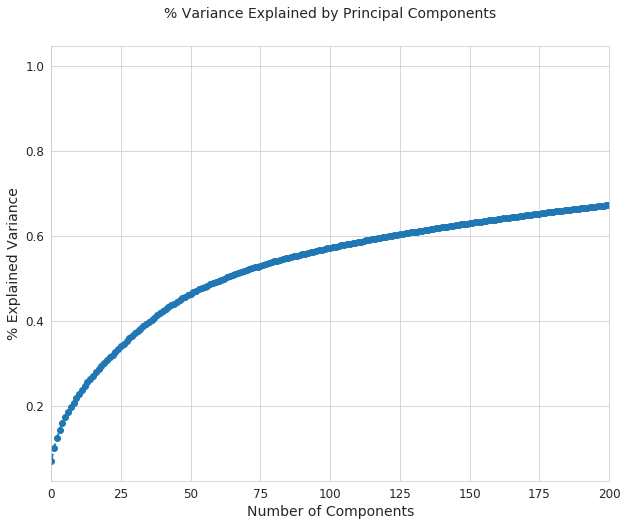

In [52]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [59]:
pca=PCA(n_components=500,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 500 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 500 components is: 0.8031828155400731


In [60]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [61]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,500).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9151595173027912
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25531  2307    27838
True         456  4273     4729
__all__    25987  6580    32567

Accuracy of the model for test data is: 0.9062883812331123
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6317   623     6940
True         140  1062     1202
__all__     6457  1685     8142



Logistic Regression
Accuracy of the model for training data is: 0.9053336199220069
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25435  2403    27838
True         680  4049     4729
__all__    26115  6452    32567

Accuracy of the model for test data is: 0.8999017440432326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6297   643     6940
True         172  1030     1202
__all__     6469  1673     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9268277704424724
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25663  2175    27838
True         208  4521     4729
__all__    25871  6696    32567

Accuracy of the model for test data is: 0.9131662982068288
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6381   559     6940
True         148  1054     1202
__all__     6529  1613     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.908434918782817
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25506  2332    27838
True         650  4079     4729
__all__    26156  6411    32567

Accuracy of the model for test data is: 0.9051830017194793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6343   597     6940
True         175  1027     1202
__all__     6518  1624     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9160499892529247
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25644  2194    27838
True         540  4189     4729
__all__    26184  6383    32567

Accuracy of the model for test data is: 0.9098501596659297
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6368   572     6940
True         162  1040     1202
__all__     6530  1612     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9293456566462984
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25668  2170    27838
True         131  4598     4729
__all__    25799  6768    32567

Accuracy of the model for test data is: 0.9127978383689511
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6378   562     6940
True         148  1054     1202
__all__     6526  1616     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9273190653115116
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25663  2175    27838
True         192  4537     4729
__all__    25855  6712    32567

Accuracy of the model for test data is: 0.9110783591255219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6360   580     6940
True         144  1058     1202
__all__     6504  1638     8142



Neural Network-1
The accuracy of the model on training data is: 0.9254152976958149


Predicted  False  True  __all__
Actual                         
False      25541  2297    27838
True         132  4597     4729
__all__    25673  6894    32567

The accuracy of the model on test data is: 0.9060427413411938


Predicted  False  True  __all__
Actual                         
False       6299   641     6940
True         124  1078     1202
__all__     6423  1719     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [62]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [63]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.915160,4273.0,25531.0,2307.0,456.0,0.082872,0.096426
LogisticRegression,0.905334,4049.0,25435.0,2403.0,680.0,0.086321,0.143794
RandomForestClassifier,0.926828,4521.0,25663.0,2175.0,208.0,0.078131,0.043984
AdaBoostClassifier,0.908435,4079.0,25506.0,2332.0,650.0,0.083770,0.137450
GradientBoostingClassifier,0.916050,4189.0,25644.0,2194.0,540.0,0.078813,0.114189
ExtraTreeClassifier,0.929346,4598.0,25668.0,2170.0,131.0,0.077951,0.027701
BaggingClassifier,0.927319,4537.0,25663.0,2175.0,192.0,0.078131,0.040601
Neural Network-1,0.925415,4597.0,25541.0,2297.0,132.0,0.082513,0.027913


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.906288,1062.0,6317.0,623.0,140.0,0.089769,0.116473,0.896879,0.695032
LogisticRegression,0.899902,1030.0,6297.0,643.0,172.0,0.092651,0.143095,0.882127,0.670970
RandomForestClassifier,0.913166,1054.0,6381.0,559.0,148.0,0.080548,0.123128,0.898162,0.708731
AdaBoostClassifier,0.905183,1027.0,6343.0,597.0,175.0,0.086023,0.145591,0.884193,0.682121
GradientBoostingClassifier,0.909850,1040.0,6368.0,572.0,162.0,0.082421,0.134775,0.891402,0.696860
ExtraTreeClassifier,0.912798,1054.0,6378.0,562.0,148.0,0.080980,0.123128,0.897946,0.707851
BaggingClassifier,0.911078,1058.0,6360.0,580.0,144.0,0.083573,0.119800,0.898313,0.704919
Neural Network-1,0.906043,1078.0,6299.0,641.0,124.0,0.092363,0.103161,0.902238,0.699259


In [64]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')